In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np


In [2]:
plt.rc("font", family="STIXGeneral", size=9)
plt.rc("figure", dpi=300)
plt.rc("savefig", dpi=300, bbox="tight", pad_inches=0.1, transparent=True, format="pdf")
plt.rc("figure", figsize=(5.3, 2.4))
plt.rc('mathtext', fontset='stix')

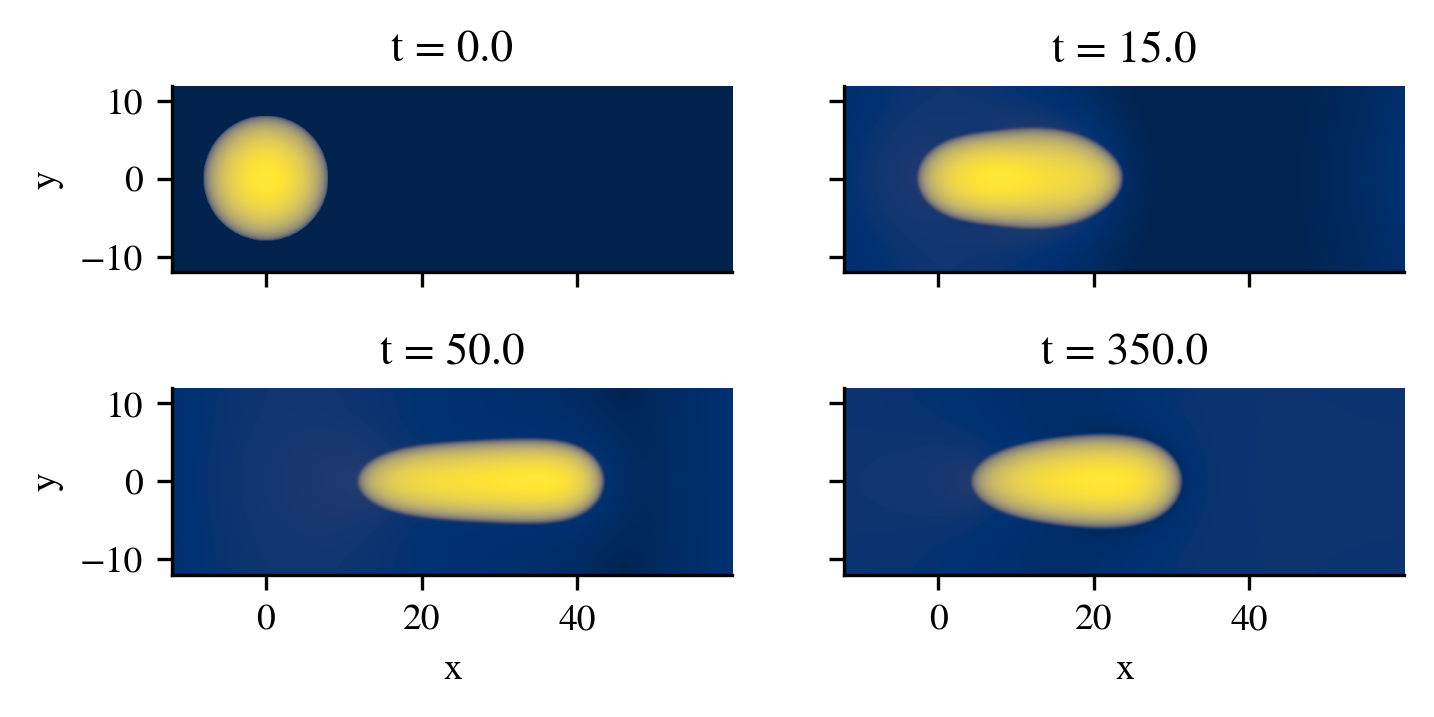

In [3]:
# fig 02
ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=0.nc")

fig, axs = plt.subplots(2, 2, figsize=(5.3, 2.4), sharex=True, sharey=True)
for ax, t in zip(axs.flat, [0, 15, 50, 350]):
    ds.h.sel(t=t).plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax,
    )
    ax.set_aspect("equal")
    sns.despine()
[ax.set_xlabel("") for ax in axs[0, :]]
[ax.set_ylabel("") for ax in axs[:, -1]]
fig.savefig(
    "../reports/figures/fig-02.one_drop_2D_h.pdf",
    dpi=300,
    bbox_inches="tight",
)


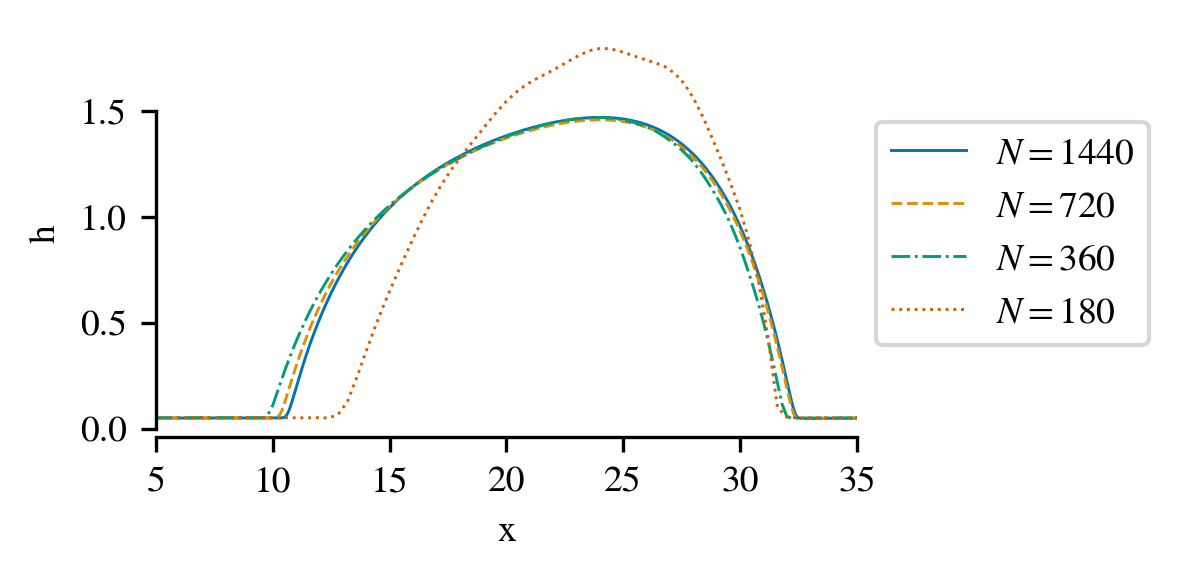

In [4]:
# fig 03
from matplotlib.rcsetup import cycler

fig, ax = plt.subplots(figsize=(4, 2))
sns.set_palette("colorblind")
ls_cycle = cycler(linestyle=["-", "--", "-.", ":"])
color_cycler = cycler(color=sns.color_palette("colorblind", n_colors=len(ls_cycle)))
ax.set_prop_cycle(ls_cycle + color_cycler)
for file in sorted(
    Path("../data/outputs/converge_N_1D/").glob("*.nc"),
    reverse=True,
    key=lambda x: float(x.stem.split("=")[1]),
):
    da = xr.open_dataset(file).h.isel(t=-1).sel(y=0)
    da = da.roll(x=len(da.x) // 2 - int(da.argmax("x")), roll_coords=False)
    da.plot(linewidth=.7, label=fr"$N={len(da.x)}$")
ax.set_title("")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_xlim(5, 35)
sns.despine(trim=True)
fig.tight_layout()
fig.savefig(
    "../reports/figures/fig-03.convergence_N_1D.pdf",
    dpi=300,
    bbox_inches="tight",
)


In [5]:
from typing import Dict
from scipy.signal import savgol_filter
from xarray import Dataset
from pathlib import Path
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt


def compute_spread_len(ds, h_factor=1.05):
    mask = ds.h > (ds.attrs["hₛ"] * h_factor)
    return mask.sum("x") * ds.x.diff("x").median()


def compute_drop_velocity(ds, filter_winlen=51, filter_polyorder=3):
    c = ds.x[ds.h.argmax("x")].diff("t")
    c = c.where((c > 0) & (c < 20)).dropna("t").interp(t=ds.t)
    c = xr.DataArray(
        data=savgol_filter(c, filter_winlen, filter_polyorder),
        coords=c.coords,
        dims=c.dims,
    )
    return c

datasets: Dict[str, Dataset] = {}
for ds in sorted(Path("../data/outputs/hs_effect_wreproj/").glob("*.nc")):
    ds = xr.open_dataset(ds).isel(y=0)
    ds["spread_len"] = compute_spread_len(ds)
    ds["drop_velocity"] = compute_drop_velocity(ds, filter_winlen=101)
    datasets[ds.attrs["hₛ"]] = ds

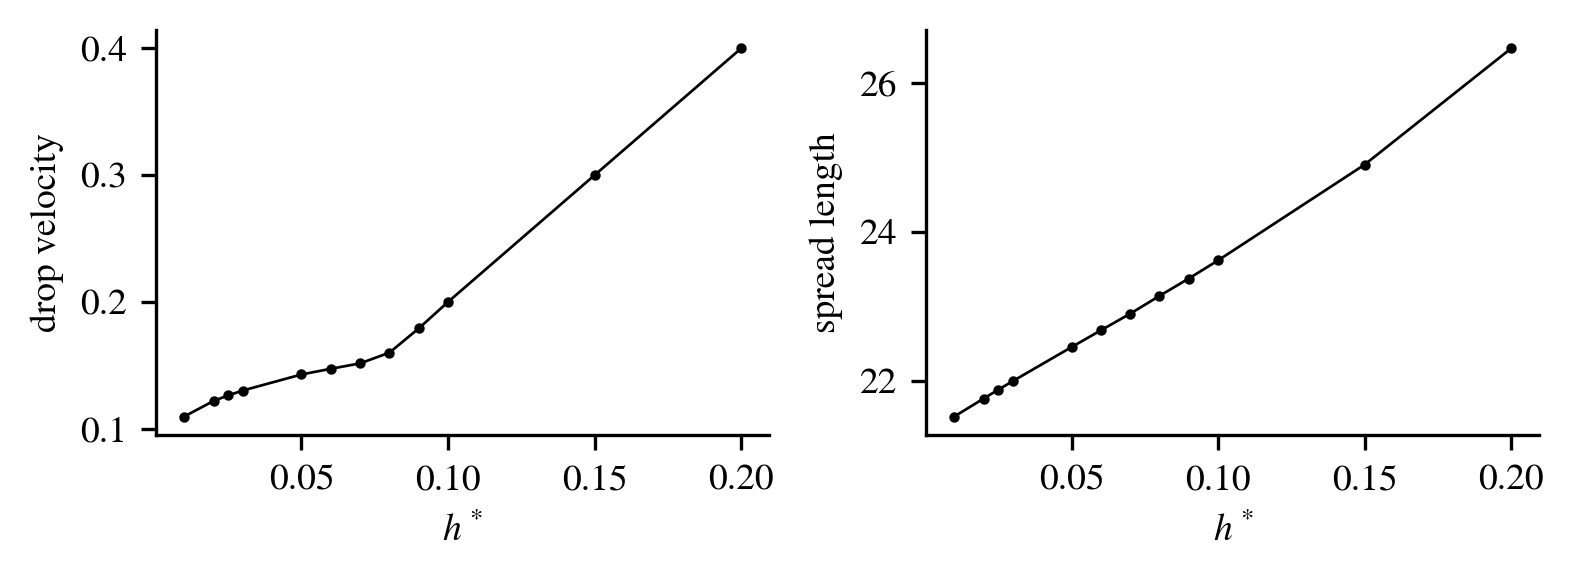

In [6]:
fig, (ax_vel, ax_spread) = plt.subplots(1, 2, figsize=(5.3, 2), sharex=True)
ax_vel.plot(
    *zip(
        *[
            (hs, ds.drop_velocity.isel(t=slice(-500, None)).mean())
            for hs, ds in datasets.items()
        ]
    ),
    marker=".",
    color="k",
    linewidth=0.65,
    markersize=3,
)
ax_vel.set_xlabel("$h^*$")
ax_vel.set_ylabel("drop velocity")
ax_vel.set_title("")

sns.despine(ax=ax_vel)

ax_spread.plot(
    *zip(
        *[
            (hs, ds.spread_len.isel(t=slice(-500, None)).mean())
            for hs, ds in datasets.items()
        ]
    ),
    marker=".",
    color="k",
    linewidth=0.65,
    markersize=3,
)

ax_spread.set_xlabel("$h^*$")
ax_spread.set_ylabel("spread length")
ax_spread.set_title("")

sns.despine(ax=ax_spread)
fig.tight_layout()
fig.savefig(
    "../reports/figures/fig-04.convergence_hs_spread_vel.pdf",
    dpi=300,
    bbox_inches="tight",
)

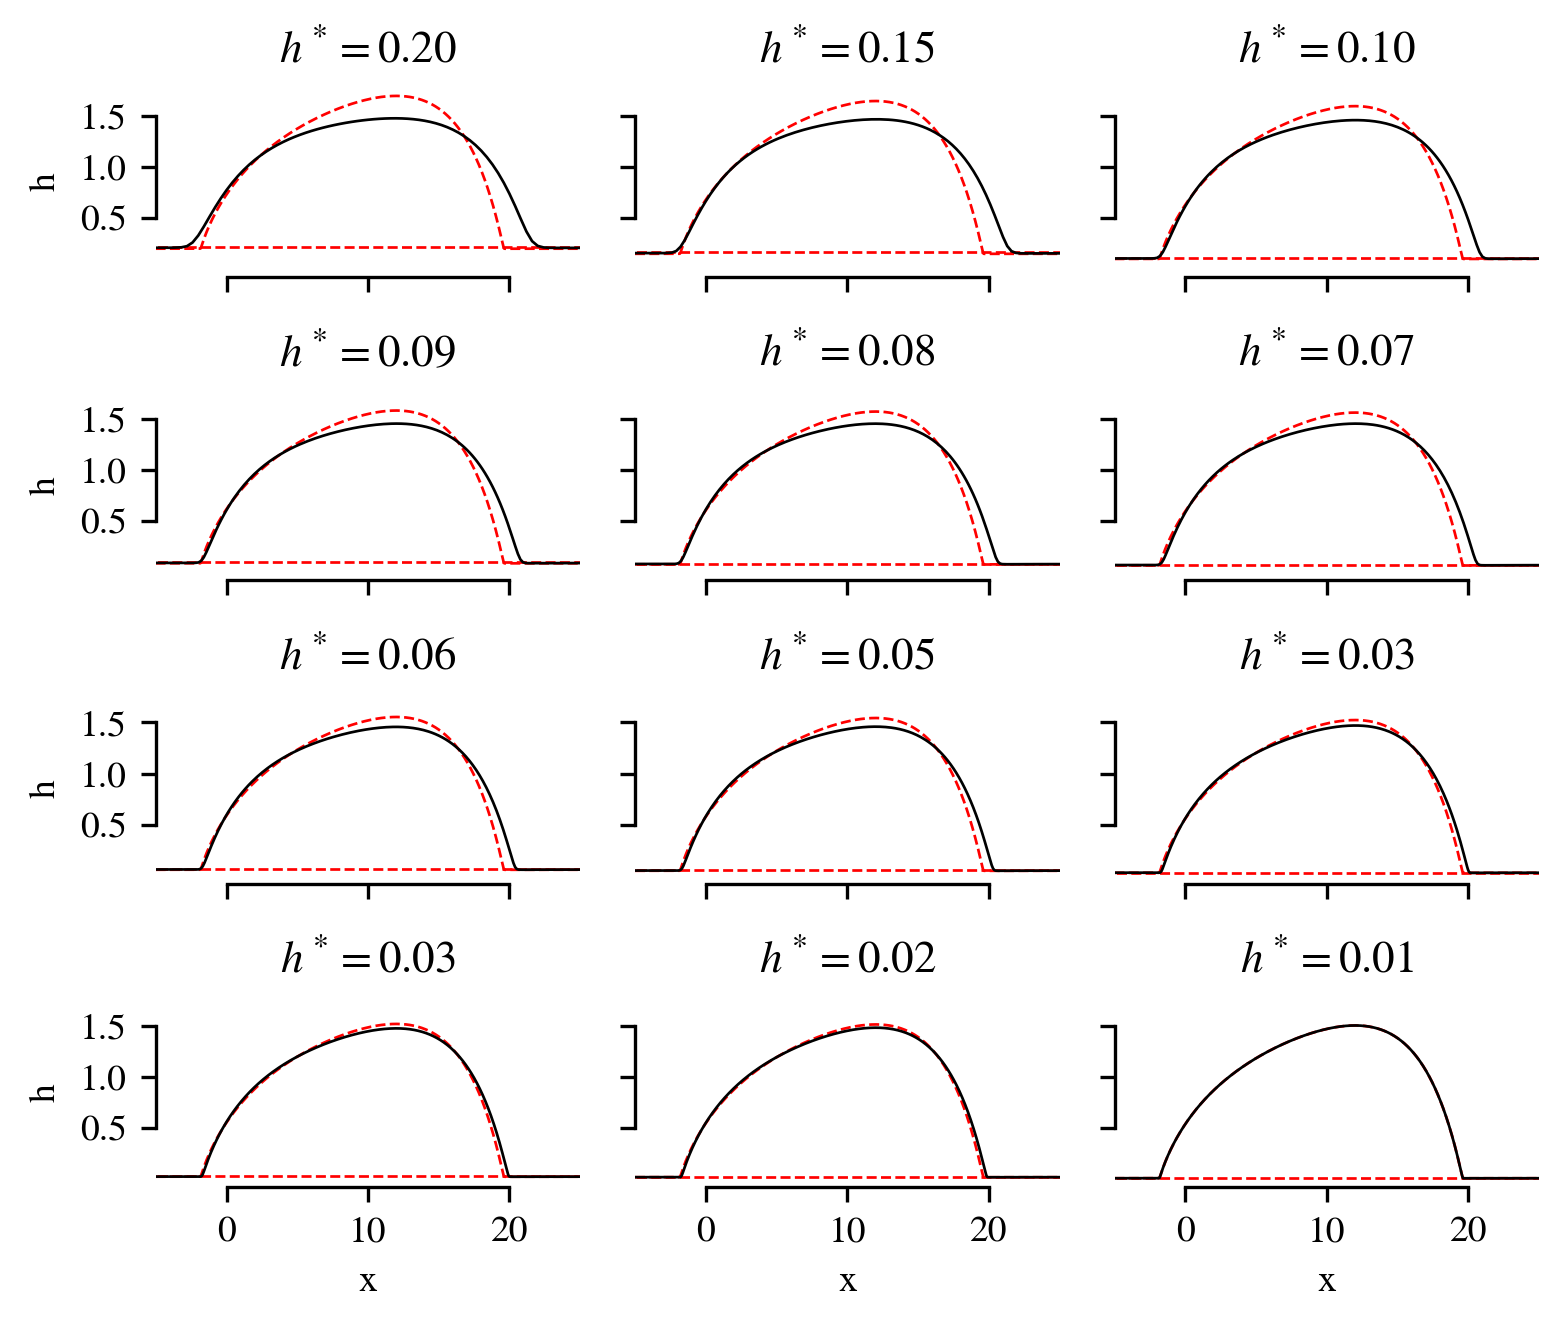

In [7]:
fig, axs = plt.subplots(
    4, 3, figsize=(5.3, 4.5), sharex=True, sharey=True, constrained_layout=True
)
ref = datasets[0.01].h.isel(t=-1)
ref = ref.roll(x=len(ref.x) // 2 - int(ref.argmax("x"))) - 0.01

for hs, ax in zip(reversed(datasets.keys()), axs.flatten()):
    ds = datasets[hs]
    xmin, xmax = ds.x.min(), ds.x.max()
    # n_traces = 10
    # step = len(ds.t) // n_traces
    # for i, t in enumerate(ds.t[::step]):
    #     if i == 0:
    #         continue
    #     frame = ds.h.sel(t=t)
    #     frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    #     frame.plot(ax=ax, color="k", alpha=(i / n_traces) * (0.8 - 0.1) + 0.1, linewidth=0.65)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    ax.hlines(ds.attrs["hₛ"] * 1.1, xmin, xmax, color="r", linestyle="--", linewidth=0.65)
    (ref + hs).plot(ax=ax, color="red", linewidth=0.65, linestyle="--")
    frame.plot(ax=ax, color="k", linewidth=0.65)
    ax.set_title(fr"$h^* = {ds.attrs['hₛ']:.2f}$")
    ax.set_xlim(-5, 25)
    sns.despine(trim=True)
[ax.set_xlabel("") for ax in axs[:-1, :].flat]
[ax.set_ylabel("") for ax in axs[:, 1:].flat]

fig.tight_layout()
fig.savefig(
    "../reports/figures/fig-05.convergence_hs_h.pdf",
    dpi=300,
    bbox_inches="tight",
)


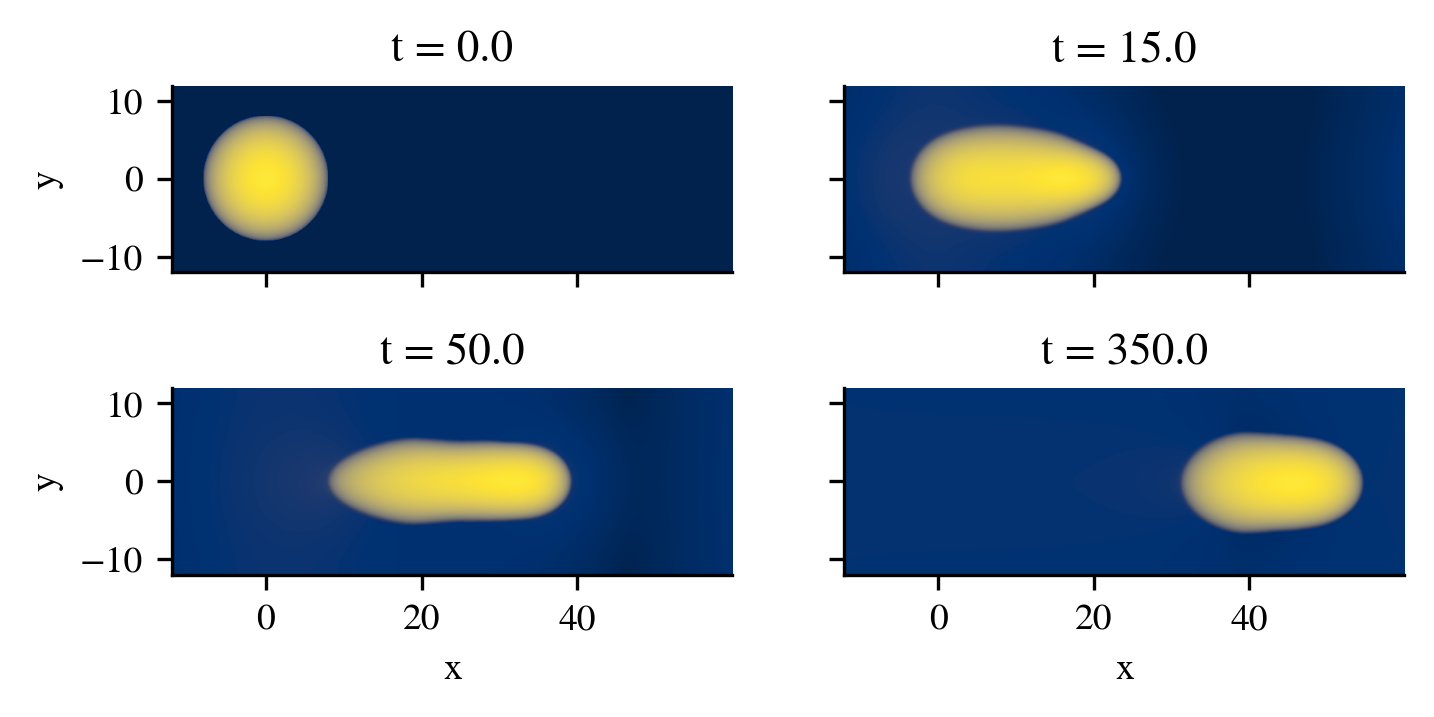

In [8]:
# fig 04
ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=5.nc")
# use serif
fig, axs = plt.subplots(2, 2, figsize=(5.3, 2.4), sharex=True, sharey=True)
for ax, t in zip(axs.flat, [0, 15, 50, 350]):
    ds.h.sel(t=t).plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax,
    )
    ax.set_aspect("equal")
    sns.despine()
[ax.set_xlabel("") for ax in axs[0, :]]
[ax.set_ylabel("") for ax in axs[:, -1]]
fig.savefig(
    "../reports/figures/fig-06.one_drop_2D_h_hyst.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [9]:
# fig 05

ds = xr.open_dataset("../data/outputs/2D_simple/dθₛ=5.nc")
ds = ds.sel(t=400)
ds = ds.roll(x=len(ds.x) // 2 - int(ds.sel(y=0).h.argmax("x")), roll_coords=False)

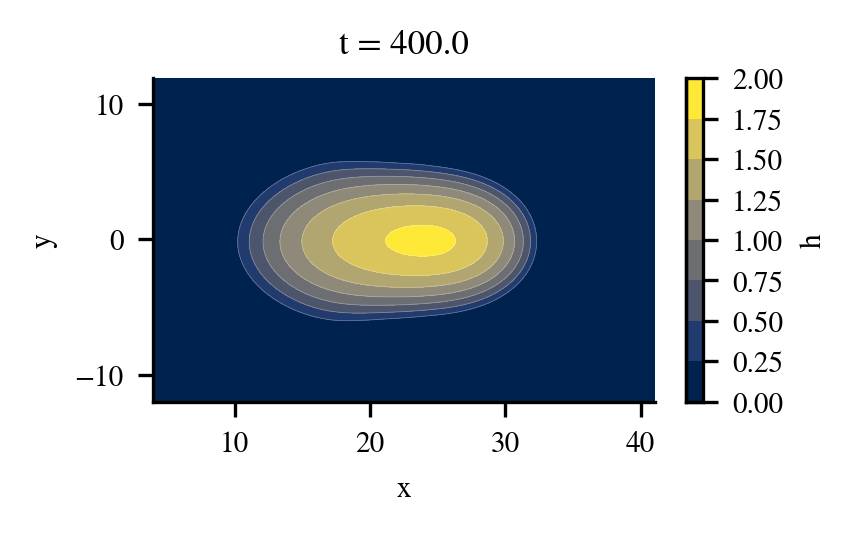

In [10]:
# (a)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "datalim")
    ds.h.plot.contourf(
        levels=np.arange(0, 2.1, 0.25),
        cmap="cividis",
        add_colorbar=True,
        ax=ax
    )
    ds.h.plot.contour(
        levels=np.arange(0, 2.1, 0.25),
        colors="white",
        linewidths=0.2,
        alpha=0.3,
        ax=ax
    )
    ax.set_xlim(5, 40)
    sns.despine()
    fig.savefig(
        "../reports/figures/fig-07.a.one_drop_2D_h_dtheta_5.pdf",
        dpi=300,
        bbox_inches="tight",
    )

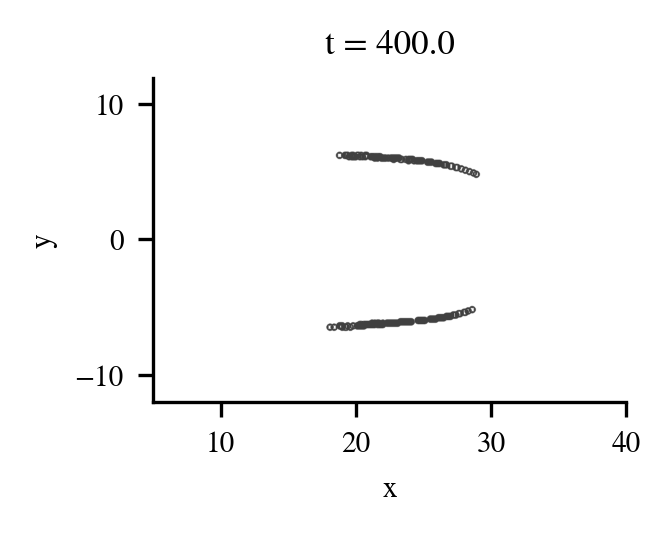

In [11]:
# (b)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_hux = (ds.h * ds.ux).differentiate("x")
    dy_huy = (ds.h * ds.uy).differentiate("y")
    div_hU = dx_hux + dy_huy

    flag = (1.2 * ds.attrs["hₛ"] < ds.h) & (ds.h < 2 * ds.attrs["hₛ"]) & (np.abs(div_hU) < 1e-3)
    flag.plot.contour(ax=ax, cmap="Greys", add_colorbar=False)

    ax.set_xlim(5, 40)
    sns.despine()
    fig.savefig(
        "../reports/figures/fig-07.b.one_drop_2D_flag_reg.pdf",
        dpi=300,
        bbox_inches="tight",
    )


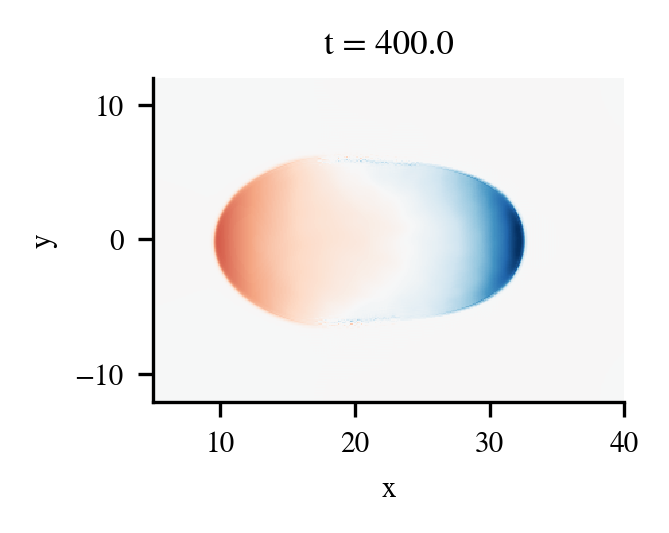

In [12]:
# (c)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_hux = (ds.h * ds.ux).differentiate("x")
    dy_huy = (ds.h * ds.uy).differentiate("y")
    div_hU = dx_hux + dy_huy
    div_hU.plot.pcolormesh(add_colorbar=False, ax=ax, rasterized=True)
    ax.set_xlim(5, 40)
    sns.despine()
    fig.savefig(
        "../reports/figures/fig-07.c.one_drop_2D_div_hU.pdf",
        dpi=300,
        bbox_inches="tight",
    )

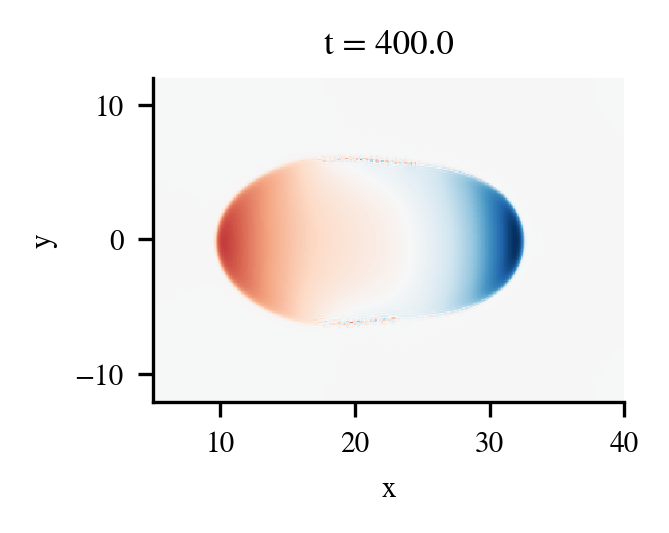

In [13]:
# (d)
with plt.rc_context({"font.size": 7}):
    fig, ax = plt.subplots(figsize=(2.7, 1.4))
    ax.set_aspect("equal", "box")

    dx_h = ds.h.differentiate("x")
    dy_h = ds.h.differentiate("y")

    U_gradh =  ds.ux * dx_h + ds.uy * dy_h
    U_gradh.plot.pcolormesh(add_colorbar=False, ax=ax, rasterized=True)
    ax.set_xlim(5, 40)
    sns.despine()

    fig.savefig(
        "../reports/figures/fig-07.d.one_drop_2D_U_gradh.pdf",
        dpi=300,
        bbox_inches="tight",
    )

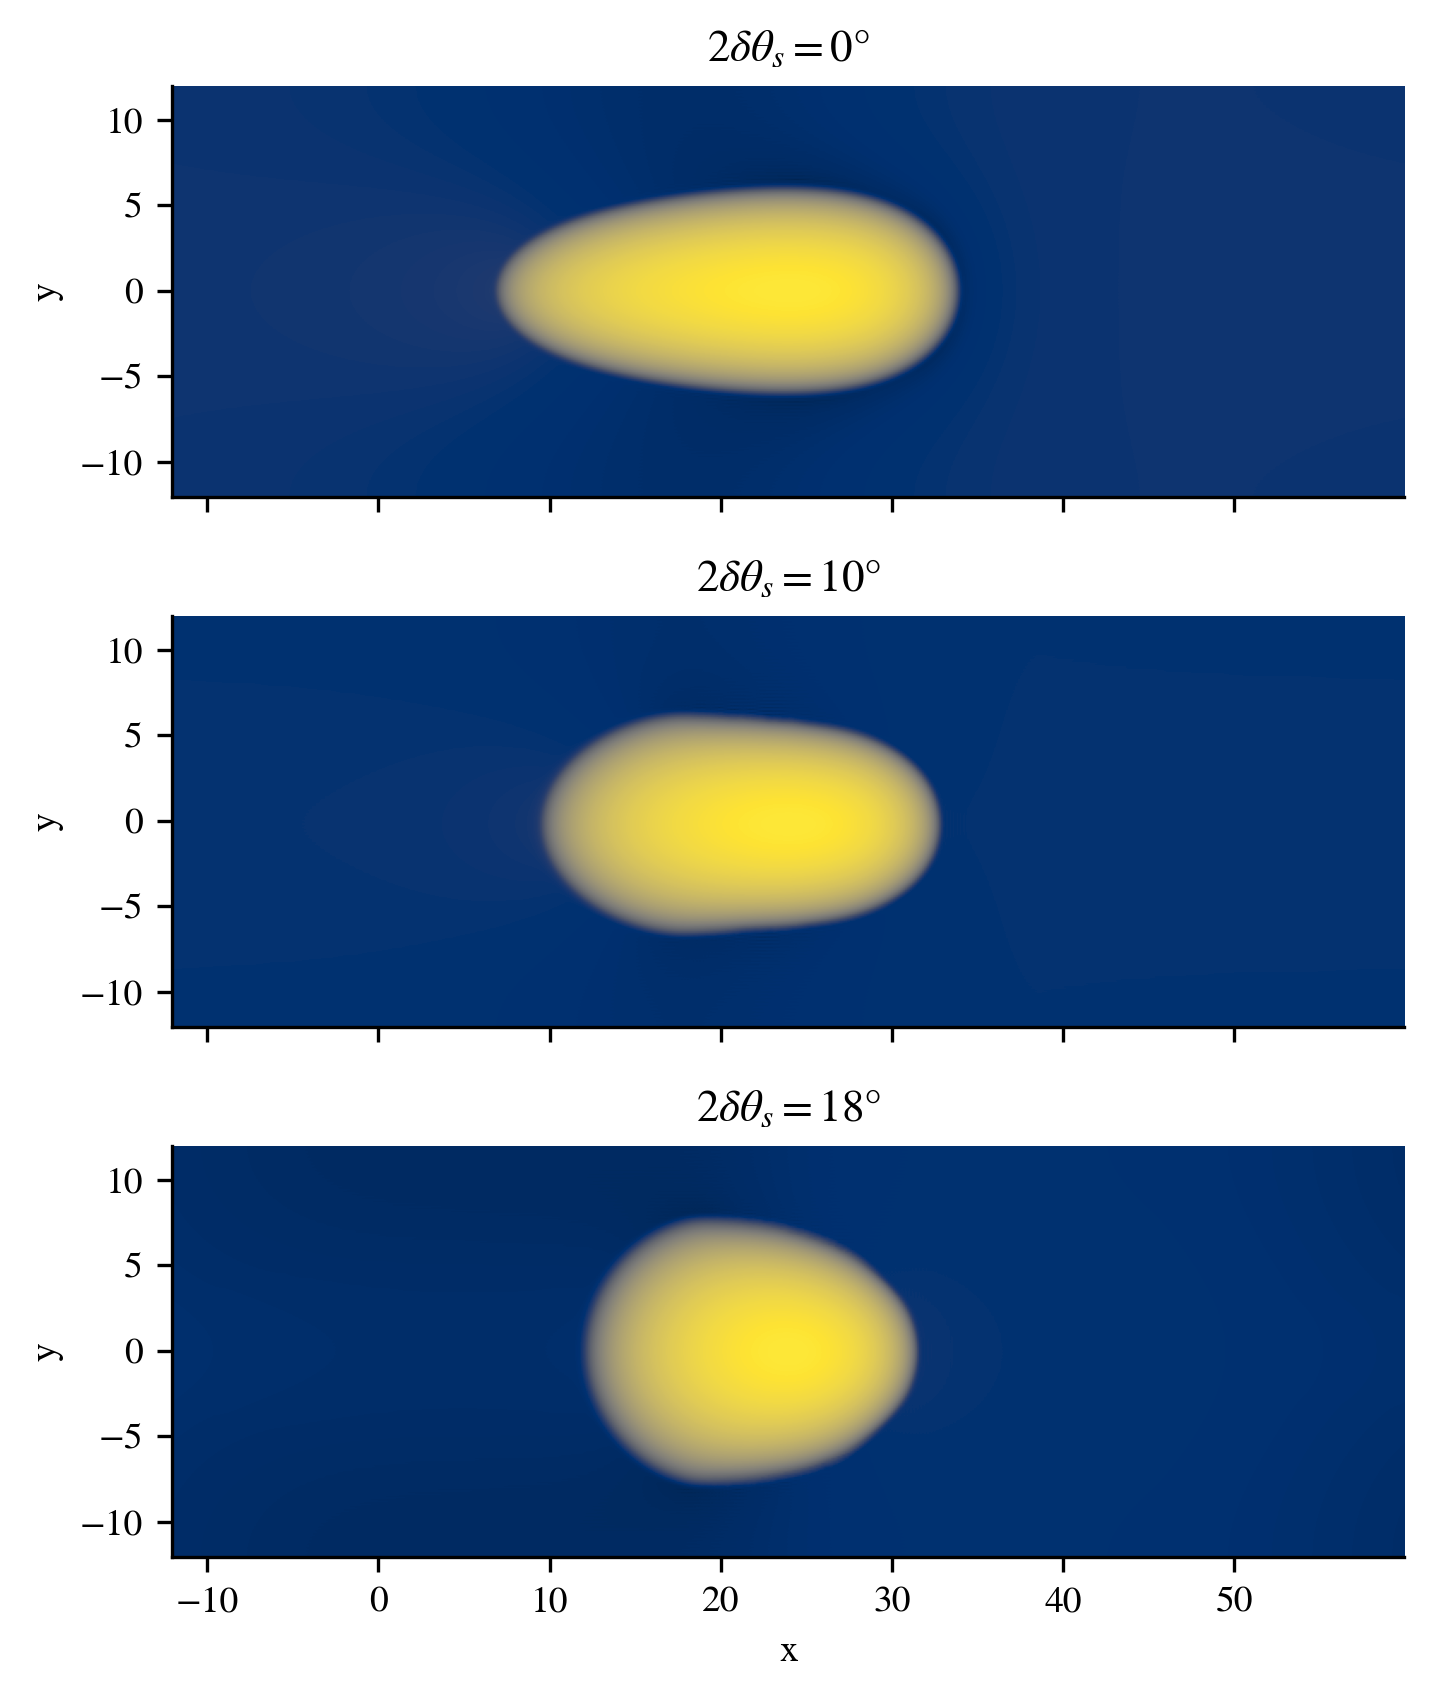

In [14]:
# fig 06
fig, axs = plt.subplots(3, 1, figsize=(5.3, 6.5), sharex=True, sharey=True)

for i, (ax, dθₛ) in enumerate(zip(axs.flat, [0, 5, 9]), start=1):
    da = xr.open_dataset(f"../data/outputs/2D_simple/dθₛ={dθₛ}.nc").h.sel(t=350)
    # center with hmax
    da = da.roll(x=len(da.x) // 2 - int(da.sel(y=0).argmax("x")), roll_coords=False)
    
    da.plot.imshow(
        cmap="cividis",
        interpolation="antialiased",
        add_colorbar=False,
        norm=plt.matplotlib.colors.PowerNorm(0.3),
        ax=ax,
    )
    ax.set_aspect("equal")
    ax.set_title(fr"$2\delta\theta_s={2*dθₛ}°$")
    sns.despine()
[ax.set_xlabel("") for ax in axs[:-1]]
fig.savefig(
    f"../reports/figures/fig-08.one_drop_2D_h_dthetas.pdf",
    dpi=300,
    bbox_inches="tight",
)

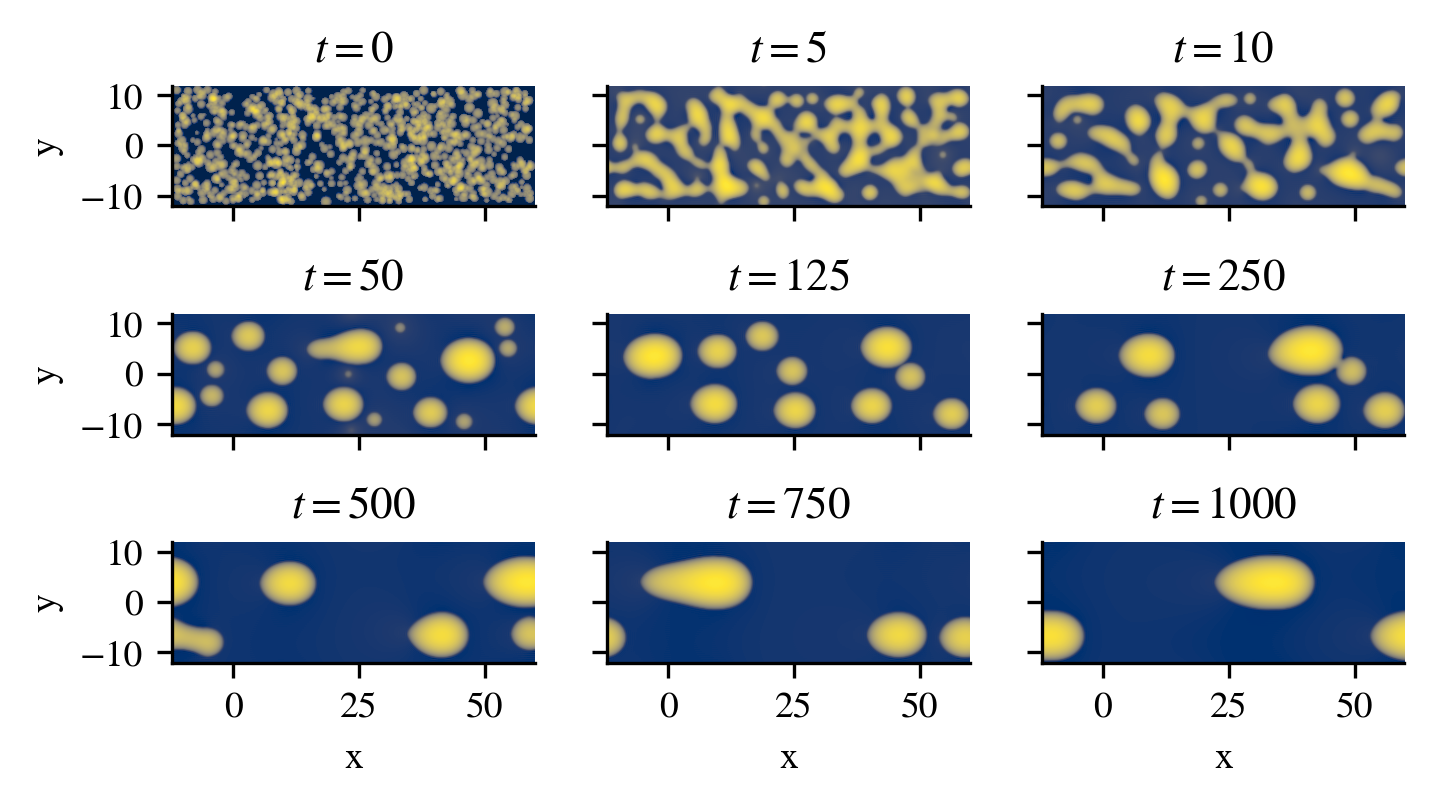

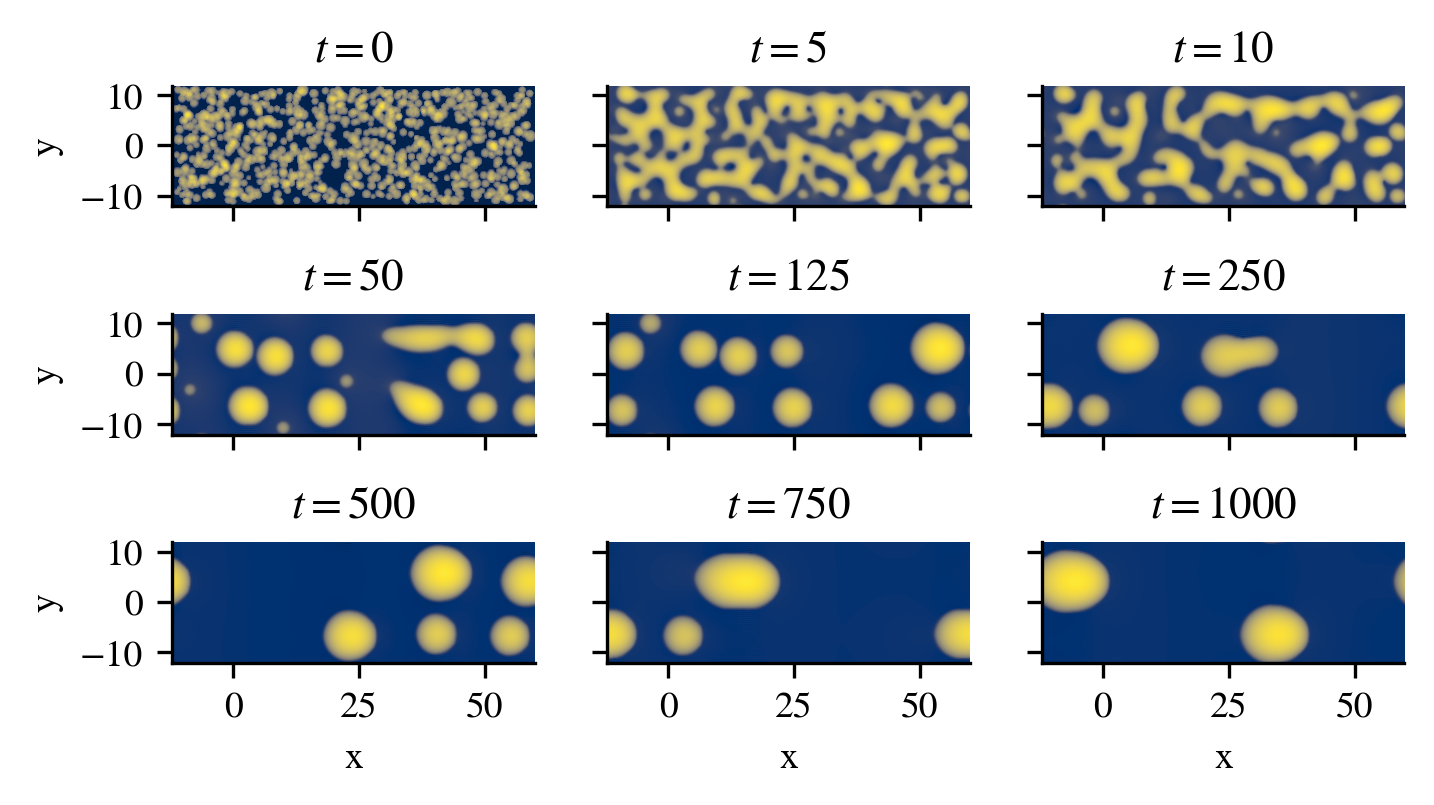

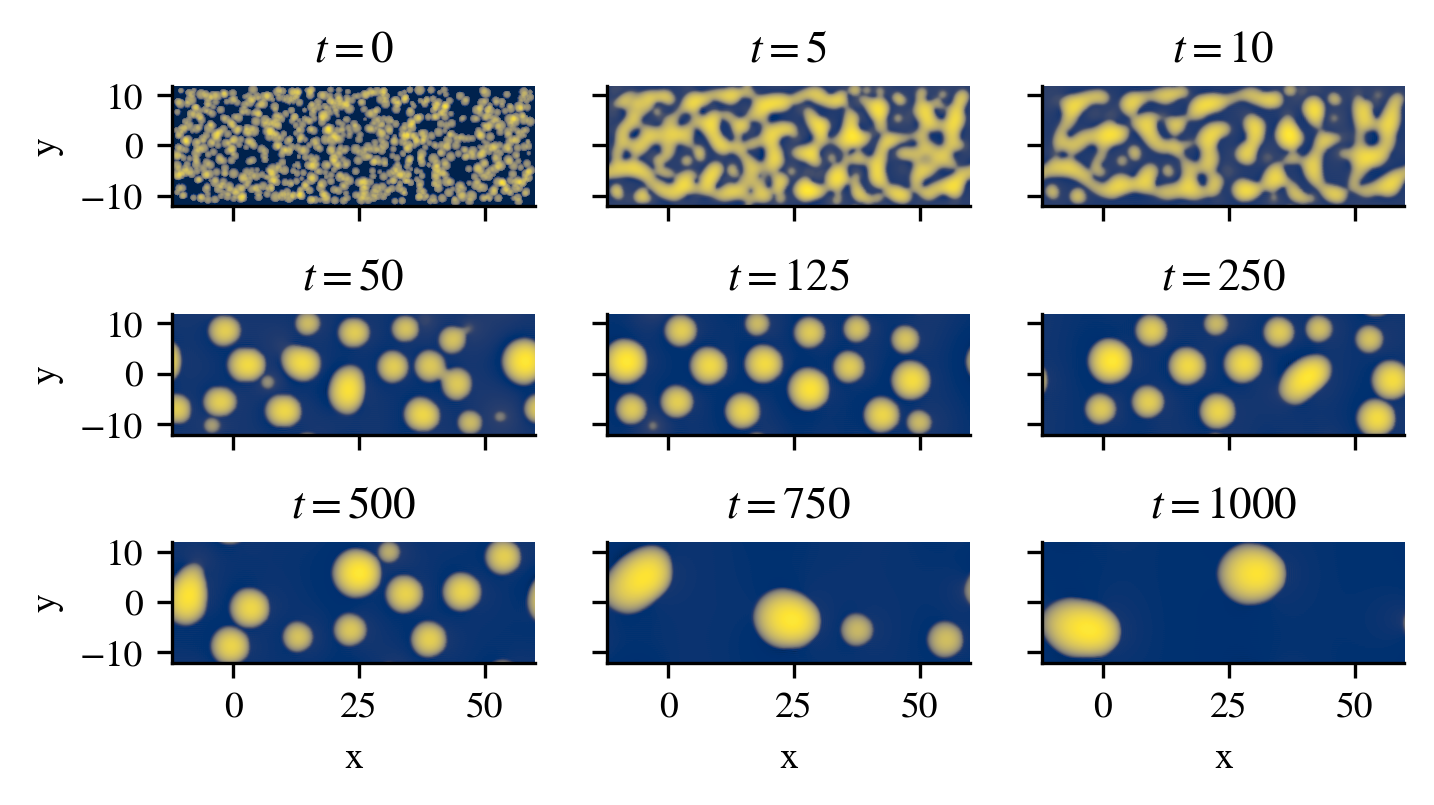

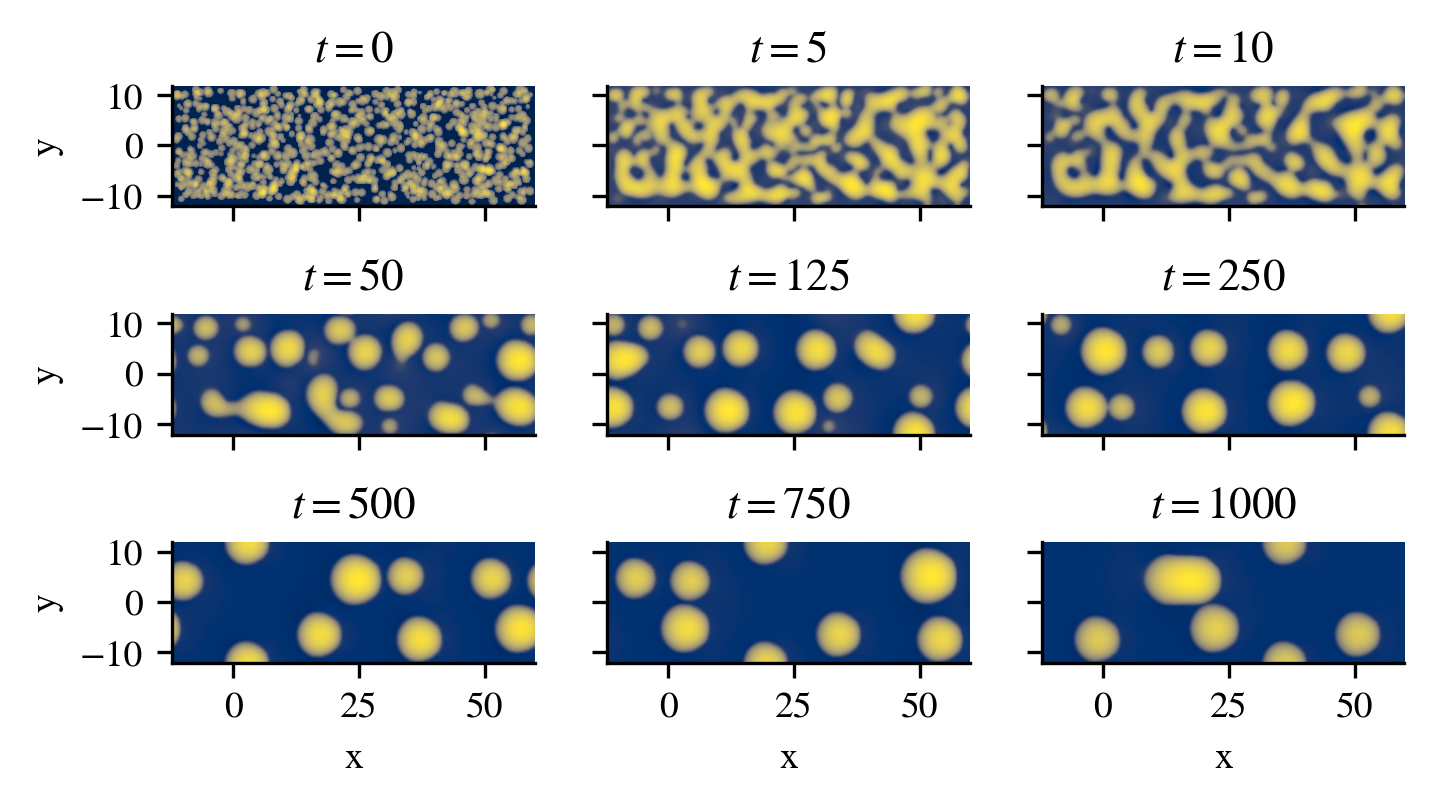

In [15]:
# fig 07+

for j, dθₛ in enumerate([0, 4, 5, 7]):
    fig, axs = plt.subplots(3, 3, figsize=(5.3, 2.8), sharex=True, sharey=True)
    ts = [0, 5, 10, 50, 125, 250, 500, 750, 1000]
    if not Path(f"../data/outputs/2D_multi_drop/dθₛ={dθₛ}.nc.done").exists():
        continue
    ds = xr.open_dataset(f"../data/outputs/2D_multi_drop/dθₛ={dθₛ}.nc").h
    for i, (ax, t) in enumerate(zip(axs.flat, ts), start=1):
        da = ds.sel(t=t)
        
        da.plot.imshow(
            cmap="cividis",
            interpolation="antialiased",
            add_colorbar=False,
            norm=plt.matplotlib.colors.PowerNorm(0.3),
            ax=ax,
        )
        ax.set_title(fr"$t={t:d}$")
        ax.set_aspect("equal")
        sns.despine()
    [ax.set_xlabel("") for ax in axs[:-1, :].flat]
    [ax.set_ylabel("") for ax in axs[:, 1:].flat];
    fig.savefig(
        f"../reports/figures/fig-{9+j:02d}.multi_drop_2D_h_dtheta_{dθₛ}.pdf",
        dpi=300,
        bbox_inches="tight",
    )